# Ablation experiments: normal traffic scenarios

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [2]:
df = pd.read_csv(
    "traversal_times.csv",
    index_col=0,
    converters={  # to convert the lists from strings to python lists
        "scenario 1": pd.eval,
        "scenario 2": pd.eval,
        "scenario 4": pd.eval,
    },
)
df

,scenario 1,scenario 2,scenario 4
foresee,"[14.156611919403076, 14.249357223510742, 13.86...","[26.483283042907715, 26.850539445877075, 27.04...","[18.851300716400146, 15.759256362915039, 15.95..."
foresee_abl_delay,"[26.02389621734619, 26.10103750228882, 26.0389...","[28.79856538772583, 28.78016233444214, 28.7197...","[23.36083745956421, 23.65060043334961, 20.3838..."
foresee_abl_fov,"[21.219999313354492, 21.04634690284729, 20.618...","[28.36388659477234, 28.346749544143677, 28.275...","[19.360669136047363, 19.62401294708252, 19.365..."
foresee_abl_lidar,"[22.077531576156616, 21.71196985244751, 21.785...","[29.003888607025146, 29.017287492752075, 29.10...","[19.822874546051025, 20.05115270614624, 19.797..."
foresee_abl_local,"[25.420146703720093, 25.418898344039917, 25.43...","[28.56868886947632, 28.803945064544678, 28.321...","[20.09068775177002, 19.737372398376465, 20.087..."
foresee_abl_traj,"[25.82274103164673, 25.697006702423096, 25.754...","[28.582420110702515, 28.445369720458984, 33.22...","[22.44888997077942, 22.410804748535156, 20.350..."
foresee_pp,"[26.625041007995605, 26.700023889541626, 26.71...","[29.55799889564514, 34.77781558036804, 33.9535...","[24.047473430633545, 23.666911125183105, 24.04..."


### 1. Plot the data

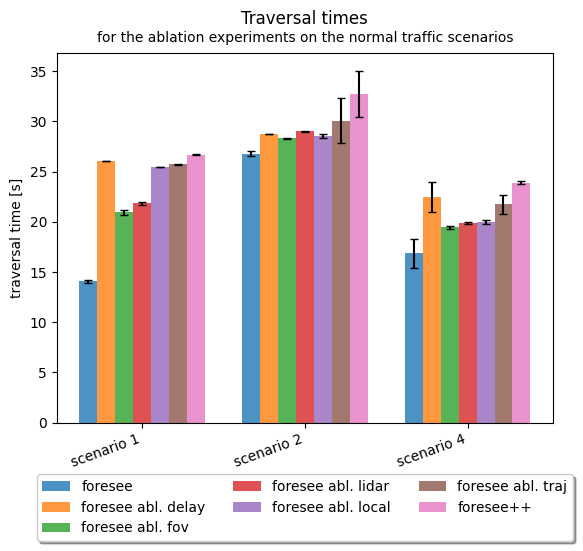

In [3]:
BAR_ALPHA = 0.8
ERROR_BAR_COLOR = "k"
width = 0.11

algorithms = np.array([i.replace("_", "").replace("abl", " abl. ").replace("pp", "++") for i in df.index])
labels = df.columns.to_list()
no_scenarios, no_algorithms = len(labels), len(algorithms)

fig, ax = plt.subplots()

xs = np.tile(np.arange(no_algorithms) * width, (no_scenarios, 1)).T + np.arange(no_scenarios)
means = df.map(np.mean).to_numpy()
stds = df.map(np.std).to_numpy()

color_iter = iter(mcolors.TABLEAU_COLORS)
for x, mean, std, algorithm in zip(xs, means, stds, algorithms):
    color = next(color_iter)
    ax.bar(x, mean, width=width, color=color, label=algorithm, alpha=BAR_ALPHA)
    ax.errorbar(x, mean, yerr=std, color=ERROR_BAR_COLOR, ls="none", barsabove=True, capsize=3)

# ax.set_title("Traversal time for all the algorithm types with\nstandard deviation over 3 runs.")
ax.set_title("Traversal times\n")
ax.text(
    0.5,
    1.03,
    "for the ablation experiments on the normal traffic scenarios",
    fontsize=10,
    ha="center",
    transform=ax.transAxes,
)
ax.set_ylabel("traversal time [s]")
ax.legend()
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), fancybox=True, shadow=True, ncol=3)
ax.set_xticks(xs.mean(axis=0), labels, rotation=20, ha="right")

plt.savefig("abl_normal_traversal_times.pdf", bbox_inches="tight")

plt.show()

### 2. Tukey's HSD

Test which ablated version have a statistical significant difference.

Results: There is a significant difference (p $<$ 0.05) between

|                          | Foresee abl. delay | Foresee abl. traject | Foresee abl. local | Foresee abl. lidar | Foresee abl. fov |
|--------------------------|--------------------|----------------------|--------------------|--------------------|------------------|
| **Foresee abl. delay**   | -                  | -                    | -                  | -                  | -                |
| **Foresee abl. traject** | false              | -                    | -                  | -                  | -                |
| **Foresee abl. local**   | false              | false                | -                  | -                  | -                |
| **Foresee abl. lidar**   | TRUE               | TRUE                 | false              | -                  | -                |
| **Foresee abl. fov**     | TRUE               | TRUE                 | false              | false              | -                |


In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols 

In [5]:
# convert the data to a dataframe with colums: [algorithm, scenario, traversal time]
data = []

algorithms_only_ablated = [
    "foresee_abl_delay",
    "foresee_abl_fov",
    "foresee_abl_lidar",
    "foresee_abl_local",
    "foresee_abl_traj",
]

for index, row in df.iterrows():
    if index not in algorithms_only_ablated:
        continue
    for scenario, times_list in row.items():
        ### Use the mean `foresee++` traversal time
        worst_foresee_pp_time = np.mean(df.loc["foresee_pp", scenario])

        for traversal_time in times_list:
            time_improvement = worst_foresee_pp_time - traversal_time
            data.append([index, scenario, time_improvement])

df_improvement = pd.DataFrame(data)
df_improvement.columns = ["algorithm", "scenario", "traversal_time_improve"]
df_improvement["algorithm"] = pd.Categorical(df_improvement['algorithm'], algorithms_only_ablated)
df_improvement.sort_values("algorithm", inplace=True)

The two-way ANOVA indicates that there is a statistical significant dependency on the algorithm version

In [6]:
# two-way ANOVA
model_two_way_no_interaction_abl_conv_traversal_times = ols(formula='traversal_time_improve ~ C(scenario) + C(algorithm)', data=df_improvement).fit()
sm.stats.anova_lm(model_two_way_no_interaction_abl_conv_traversal_times, typ=2) 

,sum_sq,df,F,PR(>F)
C(scenario),9.691209,2.0,3.088096,0.057189
C(algorithm),61.031898,4.0,9.723882,0.000016
Residual,59.626705,38.0,NaN,NaN


In [7]:
groups = []  # the values for the different algorithms

for algorithm in pd.unique(df_improvement["algorithm"]):
    # mask = (df_abl_conv_flatten["algorithm"] == algorithm) & (df_abl_conv_flatten["scenario"] == "abl_conv_scenario_18")
    mask = (df_improvement["algorithm"] == algorithm)
    groups.append(df_improvement["traversal_time_improve"][mask].tolist())

groups = np.array(groups)

In [8]:
# The Tukey HSD test
import statsmodels.stats.multicomp as multi


test = multi.MultiComparison(data=df_improvement["traversal_time_improve"], groups=df_improvement["algorithm"])
res = test.tukeyhsd()
res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
foresee_abl_delay,foresee_abl_fov,2.8485,0.0004,1.0761,4.6209,True
foresee_abl_delay,foresee_abl_lidar,2.1655,0.0099,0.3931,3.9378,True
foresee_abl_delay,foresee_abl_local,1.1085,0.3955,-0.6639,2.8809,False
foresee_abl_delay,foresee_abl_traj,-0.0975,0.9999,-1.8699,1.6749,False
foresee_abl_fov,foresee_abl_lidar,-0.683,0.8051,-2.4554,1.0894,False
foresee_abl_fov,foresee_abl_local,-1.74,0.0565,-3.5124,0.0324,False
foresee_abl_fov,foresee_abl_traj,-2.946,0.0002,-4.7184,-1.1736,True
foresee_abl_lidar,foresee_abl_local,-1.057,0.4436,-2.8293,0.7154,False
foresee_abl_lidar,foresee_abl_traj,-2.263,0.0064,-4.0353,-0.4906,True
foresee_abl_local,foresee_abl_traj,-1.206,0.3119,-2.9784,0.5664,False


In [10]:
dir(res)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_multicomp',
 '_results_table',
 '_simultaneous_ci',
 'confint',
 'data',
 'df_total',
 'groups',
 'groupsunique',
 'meandiffs',
 'plot_simultaneous',
 'pvalues',
 'q_crit',
 'reject',
 'reject2',
 'std_pairs',
 'summary',
 'variance']

In [39]:
def convert_name(group: str) -> str:
    return group.replace("_", " ").replace("abl", "abl.").replace("foresee", "foresee++")

def convert_name(group: str) -> str:
    return group.replace("_", " ").replace("abl", "abl.").replace("foresee ", "")
[convert_name(g) for g in res.groupsunique]

['abl. delay', 'abl. fov', 'abl. lidar', 'abl. local', 'abl. traj']

In [42]:
compare_groups: list[tuple[str, str]] = []
for i in range(len(res.groupsunique)):
    for j in range(len(res.groupsunique) - i - 1):
        compare_groups.append((res.groupsunique[i], res.groupsunique[j + i + 1]))

for (group1, group2), meandiff, pvalue, reject in zip(compare_groups, res.meandiffs, res.pvalues, res.reject):
    # print(f"{group1}, {group2}, {meandiff=}, {pvalue=}, {reject=}")
    # print(rf"\texttt{{{convert_name(group1)}}} & \texttt{{{convert_name(group2)}}} & {meandiff:.3f} & {pvalue:.4f} & {reject} \\")
    print(rf"\texttt{{{convert_name(group1)}}} & \texttt{{{convert_name(group2)}}} & {meandiff:.3f} & {pvalue:.4f} & {'X' if reject else ' '} \\")


\texttt{abl. delay} & \texttt{abl. fov} & 2.848 & 0.0004 & X \\
\texttt{abl. delay} & \texttt{abl. lidar} & 2.165 & 0.0099 & X \\
\texttt{abl. delay} & \texttt{abl. local} & 1.109 & 0.3955 &   \\
\texttt{abl. delay} & \texttt{abl. traj} & -0.098 & 0.9999 &   \\
\texttt{abl. fov} & \texttt{abl. lidar} & -0.683 & 0.8051 &   \\
\texttt{abl. fov} & \texttt{abl. local} & -1.740 & 0.0565 &   \\
\texttt{abl. fov} & \texttt{abl. traj} & -2.946 & 0.0002 & X \\
\texttt{abl. lidar} & \texttt{abl. local} & -1.057 & 0.4436 &   \\
\texttt{abl. lidar} & \texttt{abl. traj} & -2.263 & 0.0064 & X \\
\texttt{abl. local} & \texttt{abl. traj} & -1.206 & 0.3119 &   \\


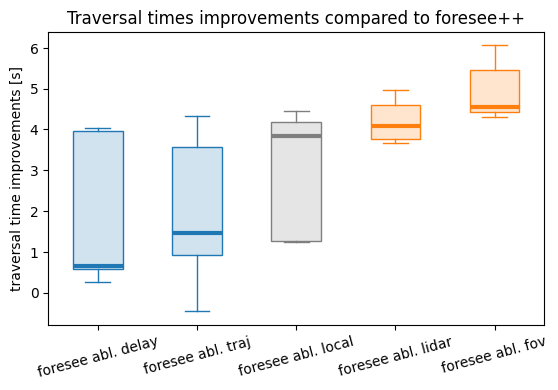

In [38]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

ranking = np.argsort(np.median(groups, axis=1))

fig, ax = plt.subplots(1, 1, figsize=(6.4, 3.8))

facealpha = 0.2
for color, slice_to_color in zip(["tab:blue", "tab:grey", "tab:orange"], [slice(0, 2), slice(2, 3), slice(3, 5)]):
    boxes = ax.boxplot(
        groups[ranking][slice_to_color].T,
        positions=np.arange(len(groups))[slice_to_color],
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor=mcolors.to_rgb(color) + (facealpha,), color=color, lw=1),
        capprops=dict(color=color),
        whiskerprops=dict(color=color),
        medianprops=dict(color=color, lw=3),
    )

ax.set_xticklabels(
    [s.replace("_", "").replace("abl", " abl. ") for s in pd.unique(df_improvement["algorithm"])[ranking]], rotation=15, ha="center"
)
ax.set_ylabel("traversal time improvements [s]")
ax.set_title("Traversal times improvements for all scenarios against\nworst foresee++ traversal time for each scenario")
ax.set_title("Traversal times improvements compared to foresee++")
plt.savefig("ablated_algorithms_tukey_hsd.pdf", bbox_inches="tight")
plt.show()